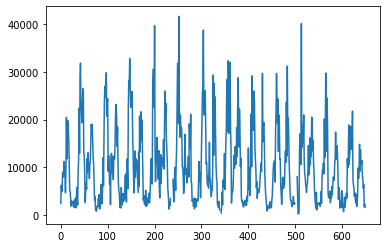

test개수:  721
Train on 3418 samples, validate on 855 samples
Epoch 1/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0119 - val_loss: 0.0056
Epoch 2/200
 150/3418 [>.............................] - ETA: 3s - loss: 0.0095

C:\Users\dlgus\Anaconda3\lib\site-packages\keras\callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `var_loss` which is not available. Available metrics are: val_loss,loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3418/3418 [==============================] - 4s 1ms/step - loss: 0.0105 - val_loss: 0.0056
Epoch 3/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 4/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0100 - val_loss: 0.0055
Epoch 5/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0099 - val_loss: 0.0064
Epoch 6/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0100 - val_loss: 0.0052
Epoch 7/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0099 - val_loss: 0.0055
Epoch 8/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0099 - val_loss: 0.0054
Epoch 9/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 10/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 11/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0094

Epoch 81/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 82/200
3418/3418 [==============================] - 4s 1ms/step - loss: 0.0062 - val_loss: 0.0049
Epoch 83/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 84/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 85/200
3418/3418 [==============================] - 5s 2ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 86/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 87/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0060 - val_loss: 0.0046
Epoch 88/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 89/200
3418/3418 [==============================] - 5s 1ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 90/200
3418/3418 [==============================] - 5s 1ms

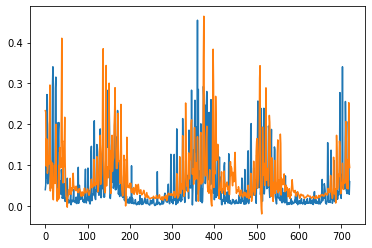

In [65]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dayfrom = 14
dayto = 42
day = dayto - dayfrom

df = pd.read_csv('seoulbigparkdata.csv', engine='python')
# print(df.head())

df["날짜"] = df["년도"].map(str) + '-' +df["월"].map(str) + '-' + df["일"].map(str)#날짜 column생성
# print(df.head())

df = df.set_index('날짜') 
# print(df.head()) 
# df.plot()

split_date_last = '2016-12-17'
split_date_start = '2017-3-30'

train = df.loc[:split_date_last, ['일계']]
test = df.loc[split_date_start:, ['일계']]
# print(train.head())

train['일계'] = train['일계'].str.replace(',', '')
test['일계'] = test['일계'].str.replace(',', '')

train['일계'] = train['일계'].astype('float')
test['일계'] = test['일계'].astype('float')

#*************************************주 단위 15년동안의 입장객수 경향************************************************

train2 = {}
for i in range(int(len(train)/7)):
    train1 = train['일계'][i*7:i*7+7]
    train2[i] = train1.mean(axis = 0) 

trainlist = list(train2.values())
# print(trainlist)

plt.plot(trainlist)
plt.show()

#***********************************************************************************************************************

from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

# print(train_sc)

train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
# print(train_sc_df.head())

for s in range(dayfrom, dayto):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
# print(X_train.head())
# print(y_train.head())

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

# print(X_train.head())

X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

X_train_t = X_train.reshape(X_train.shape[0], day, 1)
X_test_t = X_test.reshape(X_test.shape[0], day, 1)

print('test개수: ', len(y_test))
# print(X_test_t.shape)

from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping
from keras import optimizers
K.clear_session()
model = Sequential() # Sequeatial Model 
model.add(LSTM(56, input_shape=(day, 1), return_sequences = True)) # (timestep, feature)
model.add(LSTM(56))
model.add(Dense(1)) # output = 1 
adam = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=adam) 
# print(model.summary())

early_stop = EarlyStopping(monitor='var_loss', patience=30, verbose=1)

model.fit(X_train_t, y_train, epochs=200,
          batch_size=30, verbose=1, validation_split = 0.2, callbacks=[early_stop])

plt.plot(y_test)

y_pred = model.predict(X_test_t)

plt.plot(y_pred)
plt.show()